# Q2 - MLP - IFT6135

## Important librairies

In [172]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import random
import pickle
import gzip

import time
import datetime
import os

from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import issparse
from scipy.sparse import vstack

def standardization(xx):
    n,m = xx.shape
    eps = 1e-5
    std = np.std(xx,axis=0)
    u_j = np.mean(xx,axis=0)
    return (xx - u_j)/(std+eps)


def adjust_lr(optimizer, lr0, epoch, total_epochs):
    lr = lr0 * (0.36 ** (epoch / float(total_epochs)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def prediction_minibatch(pred_batch,y):
    correct = 0
    total = 0
    _, pred = torch.max(pred_batch.data, 1)
    pred = Variable(pred)
    total += float(y.size(0))
        
    correct += float((pred == y).sum())
    return 100*correct/total


def prediction(data_batch,model):
    correct = 0
    total = 0
    for x, y in data_batch:
        x,y = model.input(x,y)
        out = model.forward(x)
        _, pred = torch.max(out.data, 1)
        pred = Variable(pred)
        total += float(y.size(0))
        
        correct += float((pred == y).sum())
    return 100*correct/total


def linear_ini(LL,initialization):
    '''
    inputs : linear layer (LL) and the initialization
    output : linear layer with the chosen initialization
    '''
    if initialization == 'zero':
        LL.weight.data = nn.init.constant(LL.weight.data, 0)
        LL.bias.data = nn.init.constant(LL.bias.data, 0)
    
    if initialization == 'normal':
        LL.weight.data = nn.init.normal(LL.weight.data, 0,1)
        LL.bias.data = nn.init.normal(LL.bias.data, 0,1)

    if initialization == 'glorot':
        LL.weight.data = nn.init.xavier_uniform(LL.weight.data, gain=1)
        LL.bias.data = nn.init.constant(LL.bias.data, 0)
    if initialization == 'default': 
        pass
        
    return LL

## MLP class

In [217]:

class MLPLinear(nn.Module):
	def __init__(self, dimensions, cuda):
		super(MLPLinear, self).__init__()
		self.h0 = dimensions[0]
		self.h1 = dimensions[1]
		self.h2 = dimensions[2]        

		self.fc1 = torch.nn.Linear(self.h0,self.h1)
		self.fc2 = torch.nn.Linear(self.h1,self.h2)        
		self.relu = nn.ReLU()
		self.criterion = nn.CrossEntropyLoss()
		self.cuda = cuda

		if cuda: 
			self.fc1.cuda()
			self.fc2.cuda()
			self.relu.cuda()
			self.criterion.cuda()

	def initialization(self,method):
		self.fc1 = linear_ini(self.fc1,method)
		self.fc2 = linear_ini(self.fc2,method)

	def input(self,x,y):
		if self.cuda : 
			x = Variable(x.cuda())
			y = Variable(y.cuda())
		else: 
			x = Variable(x)
			y = Variable(y)
		return x,y
        
    
	def forward(self, x):
		out = self.fc1(x)
		out = self.relu(out)
		out = self.fc2(out)
		return  out

## Loading the data

In [6]:
######################################################################################################################################################
######################################################################################################################################################
######################################################################################################################################################
######################################################################################################################################################
######################################################################################################################################################
######################################################################################################################################################


path1 = "./20news-bydate/"
vocabulary = np.loadtxt(os.path.join(path1, "vocabulary.txt"), dtype = str)

path2 = path1 + "matlab/"

train_valid_x_ = np.loadtxt(os.path.join(path2, "train.data"), dtype = np.uint16)
train_valid_y_ = np.loadtxt(os.path.join(path2, "train.label"), dtype = np.uint8)
test_x_ = np.loadtxt(os.path.join(path2, "test.data"), dtype = np.uint16)
test_y_ = np.loadtxt(os.path.join(path2, "test.label"), dtype = np.uint8)

n_words_vocabulary = len(vocabulary)
n_doc_train_data = int(train_valid_x_[-1,0])
n_doc_test_data = int(test_x_[-1,0])

train_valid_x = np.empty((n_doc_train_data, n_words_vocabulary))
test_x = np.empty((n_doc_test_data, n_words_vocabulary))


### Filling of train_x and test_x from train_data and test_data
for i in range(train_valid_x_.shape[0]):
    j,k,l = train_valid_x_[i]
    train_valid_x[j-1,k-1]=l

for i in range(test_x_.shape[0]):
    j,k,l = test_x_[i]
    test_x[j-1, k-1]=l


documents_x = vstack([train_valid_x, test_x])
inv_idf = ((documents_x != 0).sum(axis = 0))
idf = np.log(documents_x.shape[0]/inv_idf)

train_valid_x_idf = np.multiply(train_valid_x,idf)
test_x_idf = np.multiply(test_x,idf)
train_valid_x_std = standardization(train_valid_x)
test_x_std = standardization(test_x)

train_valid_x = torch.FloatTensor(train_valid_x)
train_valid_x_idf = torch.FloatTensor(train_valid_x_idf)
train_valid_x_std = torch.FloatTensor(train_valid_x_std)
train_valid_labels = torch.FloatTensor(train_valid_y_-1)

test_data = torch.FloatTensor(test_x)
test_data_idf = torch.FloatTensor(test_x_idf)
test_data_std = torch.FloatTensor(test_x_std)
test_labels = torch.FloatTensor(test_y_-1)


torch.manual_seed(1000)

ind = torch.randperm(train_valid_x.shape[0])
train_valid_x = train_valid_x[ind]
train_valid_x_idf = train_valid_x_idf[ind]
train_valid_x_std = train_valid_x_std[ind]
train_valid_labels = train_valid_labels[ind]


train_x = train_valid_x[:9015]
train_x_idf = train_valid_x_idf[:9015]
train_x_std = train_valid_x_std[:9015]
train_y = train_valid_labels[:9015].long()

valid_x = train_valid_x[9015:]
valid_x_idf = train_valid_x_idf[9015:]
valid_x_std = train_valid_x_std[9015:]
valid_y = train_valid_labels[9015:].long()

test_x = test_data
test_x_idf = test_data_idf
test_x_std = test_data_std
test_y = test_labels.long()

print('Data Loaded')


######################################################################################################################################################
######################################################################################################################################################
######################################################################################################################################################
######################################################################################################################################################
######################################################################################################################################################

Data Loaded


In [220]:
# this is a test - for Iban. 
batch_size = 20
num_epochs = 20
lr0 = 0.01

h0 = 61188    #784
h1 = b1 = 100
h2 = b2 = 20
cuda = False


model = MLPLinear([h0,h1,h2],cuda) 
model.initialization('glorot')
xt,yt = model.input(train_x,train_y)
pred_batch = model(xt)
print(pred_batch.shape)
loss_batch = model.criterion(pred_batch,yt)
print('sucess!')

torch.Size([9015, 20])
sucess!


## Training routine

### Choice of hyperparameters

__The hyperparameters were updated manually. For each training sequence, the loss, the accuracy and the hyperparameters were 'pickled'. The next coding cell plots each pickle file. __

In [228]:

np.random.seed(seed=None)

cuda = False
h0 = 61188
h1 = b1 = 100
h2 = b2 = 20
num_epochs = 1

initialization_method = ['tf_idf']
batch_size = [133,133,133]
lr0 = [0.0078,0.0078,0.0078]

nb_hp = 10

hyperparameters=np.empty((nb_hp,2))
for i in range(nb_hp):
    hyperparameters[i,:] = np.concatenate((np.array((150, )), np.random.uniform(0.0001,0.1,1))).reshape(1,2)
    
#np.random.randint(20,300,1)

# learning rate
# hyperparameters = np.hstack((150* np.ones(12).reshape(12,1),np.logspace(-5.,-1, num=12).reshape(12,1)))

hyperparameters = np.hstack((np.array((50,100)).reshape(2,1),np.array((0.1,0.1)).reshape(2,1)))
hp = []
# for i,h in enumerate(hyperparameters):
#     hp.append([h[0],h[1],'no_processing'])
# for i,h in enumerate(hyperparameters):    
#     hp.append([h[0],h[1],'tf_idf'])
for i,h in enumerate(hyperparameters):    
    hp.append([h[0],h[1],'tf_idf'])    
print((hp))

[[50.0, 0.10000000000000001, 'tf_idf'], [100.0, 0.10000000000000001, 'tf_idf']]


### Training! 

In [ ]:
n = len(hp)
m = num_epochs
loss_train = np.empty([n,m]) 
loss_valid = np.empty([n,m]) 
acc_train = np.empty([n,m]) 
acc_valid = np.empty([n,m]) 
lr = np.empty([n,m]) 

bs = batch_size[0]
lrs = lr0[0]

for i, (bs, lrs, method_) in enumerate((hp)):
    t0 = time.time()
    print('Iteration: '+str(i)+'/'+str(n))
    model = MLPLinear([h0,h1,h2],cuda)
    model.initialization('glorot')
    optimizer = optim.SGD(model.parameters(),lr=lrs,momentum=0.9)
    if method_ == 'no_processing':
        xt = train_x
        yt = train_y
        xv = valid_x
        yv = valid_y

    elif method_ == 'tf_idf':
        xt = train_x_idf
        yt = train_y
        xv = valid_x_idf
        yv = valid_y

    elif method_ == 'standardization':
        xt = train_x_std
        yt = train_y
        xv = valid_x_std
        yv = valid_y
  
    else: print('You made a mistake, pal! ')
    
    train_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(xt,yt), batch_size=bs, shuffle=True)
    valid_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(xv,yv), batch_size=bs, shuffle=False)

    print('     ')
    print('     ')    
    print('Preprocessing procedures : '+method_+'   bs ='+str(bs)+'   lrs ='+str(lrs))
    print('________________________________')    
    for j in range(num_epochs):
        model_loss = 0
        for batch_idx, (xx,yy) in enumerate(train_batch):
            xx,yy = model.input(xx,yy)
            pred_batch = model.forward(xx)

            optimizer.zero_grad()
            loss_batch = model.criterion(pred_batch,yy)
            loss_batch.backward()
            optimizer.step()  
            
            if batch_idx%50 ==0 : print(loss_batch.data[0])
        print(ii)
        xt_,yt_ = model.input(xt,yt)
        xv_,yv_ = model.input(xv,yv)
        pred_train_all = model.forward(xt_)
        pred_valid_all = model.forward(xv_)  
  
        loss_train[i,j] = model.criterion(pred_train_all,yt_).data[0]
        loss_valid[i,j] = model.criterion(pred_valid_all,yv_).data[0]


        acc_train[i,j]  = prediction(train_batch,model)
        acc_valid[i,j]  = prediction(valid_batch,model)
            
        lr_ = adjust_lr(optimizer,lrs, j+1, num_epochs)
#         if j%5 == 0: print('Epoch #'+str(j)+', Train loss = '+str(loss_train[i,j])+', Valid loss = '+str(loss_valid[i,j]))
    ts = time.time()
    print('Time = %.2f sec'%(ts - t0))
print('done!')



### Processing methods 

In [231]:
with open('SaveData/Q2/hunt_for_best_parameters', 'rb') as f:
    loss_train, loss_valid, acc_train, acc_valid, hp  = pickle.load(f)

In [232]:
hp_star_epoch = np.argmax(acc_valid,axis=1)
max_acc = np.max(np.max(acc_valid,axis=1))
hp_star_ind = np.argmax(np.max(acc_valid,axis=1))

print(max_acc)


89.884649512


In [233]:
acc_max_no_processing = 0
acc_max_tf_idf = 0
acc_max_std = 0
for i,hp_ in enumerate(hp):
    if hp_[2] == 'no_processing':
        acc_max = np.max(acc_valid[i,:])
        if acc_max > acc_max_no_processing:
            acc_max_no_processing = acc_max
            arg_max_no_processing = i
    if hp_[2] == 'tf_idf':
        acc_max = np.max(acc_valid[i,:])
        if acc_max > acc_max_tf_idf:
            acc_max_tf_idf = acc_max
            arg_max_tf_idf = i
    if hp_[2] == 'standardization':
        acc_max = np.max(acc_valid[i,:])
        if acc_max > acc_max_std:
            acc_max_std = acc_max
            arg_max_std = i
            

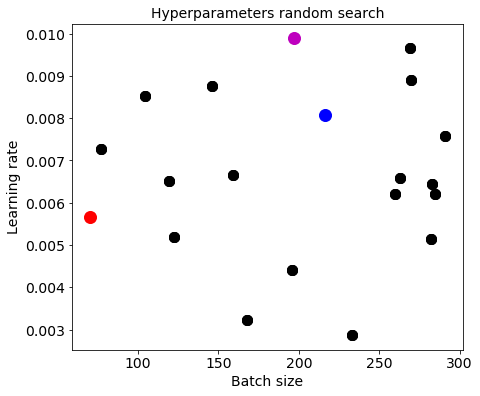

In [236]:
fig, (ax) = plt.subplots(1,figsize=(7,6))

for i, hp_ in enumerate((hp)):
    ax.plot(hp_[0],hp_[1],'ok',markersize=10)
    

ax.plot(hp[arg_max_no_processing][0],hp[arg_max_no_processing][1],'or',markersize=12)
ax.plot(hp[arg_max_tf_idf][0],hp[arg_max_tf_idf][1],'ob',markersize=12)
ax.plot(hp[arg_max_std][0],hp[arg_max_std][1],'om',markersize=12)
        
ax.set_ylabel('Learning rate',fontsize=14)
ax.set_xlabel('Batch size',fontsize=14)
ax.set_title('Hyperparameters random search')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(14)        
plt.show()        
    
fig.savefig('Figures/Q2_RandomWalk.pdf')

 

Hyperparameters and methods
______________________________
              
[70.0, 0.0056596331531257879, 'no_processing']
[216.0, 0.0080866290367637029, 'tf_idf']
[197.0, 0.0098851961387014537, 'standardization']
______________________________
              
              
Best validation accuracy
______________________________
              
No processing validation accuracy : 82.4
TF IDF validation accuracy : 89.9
Standardization validation accuracy : 85.4


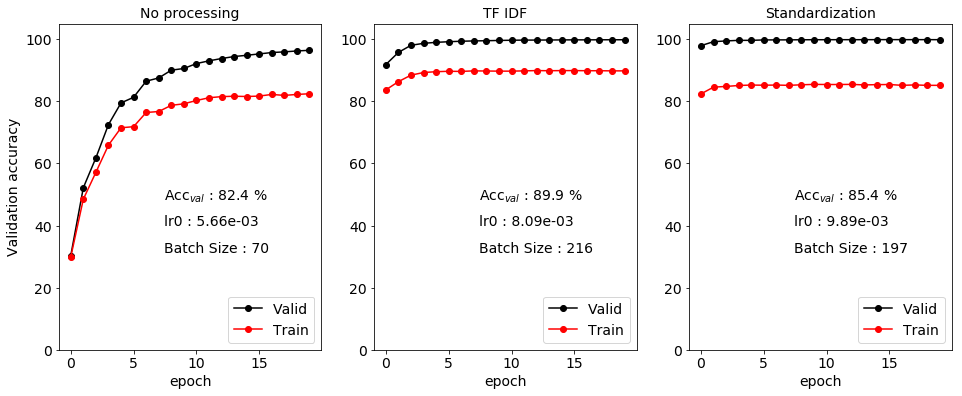

In [237]:



print('Hyperparameters and methods')
print('______________________________')
print('              ')
print(hp[arg_max_no_processing])
print(hp[arg_max_tf_idf])
print(hp[arg_max_std])
print('______________________________')
print('              ')
print('              ')

title = ['No processing','TF IDF','Standardization']
print('Best validation accuracy')
print('______________________________')
print('              ')
print('No processing validation accuracy : %.1f'%acc_max_no_processing)
print('TF IDF validation accuracy : %.1f'%acc_max_tf_idf)
print('Standardization validation accuracy : %.1f'%acc_max_std)

acc_ = [acc_max_no_processing,acc_max_tf_idf,acc_max_std]
hp_ = [arg_max_no_processing,arg_max_tf_idf,arg_max_std]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,6))
axis = [ax1,ax2,ax3]
title = ['No processing','TF IDF','Standardization']
for i, (ax,title,hp_,acc_) in enumerate(zip(axis,title,hp_,acc_)):
    ax.plot(acc_train[hp_,:],'o-',color='k')
    ax.plot(acc_valid[hp_,:],'o-',color='r')
    ax.set_ylim((0,105))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(14)
    ax.set_xlabel('epoch',fontsize=14)

    ax.set_title(title,fontsize=14)
    legend = ax.legend(['Valid','Train'],loc='lower right',fontsize=14)
    
    coordinates = [(ax.get_xlim()[1] - ax.get_xlim()[0]), (ax.get_ylim()[1] - ax.get_ylim()[0])]
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.text(0.4*(xmax - xmin) + xmin, 0.3*(ymax-ymin) + ymin,'Batch Size : '+'%.f'%hp[hp_][0], fontsize=14)
    ax.text(0.4*(xmax - xmin) + xmin, 0.38*(ymax-ymin) + ymin,'lr0 : '+'%.2e'%hp[hp_][1], fontsize=14)    
    ax.text(0.4*(xmax - xmin) + xmin, 0.46*(ymax-ymin) + ymin,'Acc$_{val}$ : '+'%.1f %%'%acc_, fontsize=14)        
    

ax1.set_ylabel('Validation accuracy',fontsize=14)

plt.show()  

fig.savefig('Figures/Q2_ProcessingMethods.pdf')







### Learning rate dependence

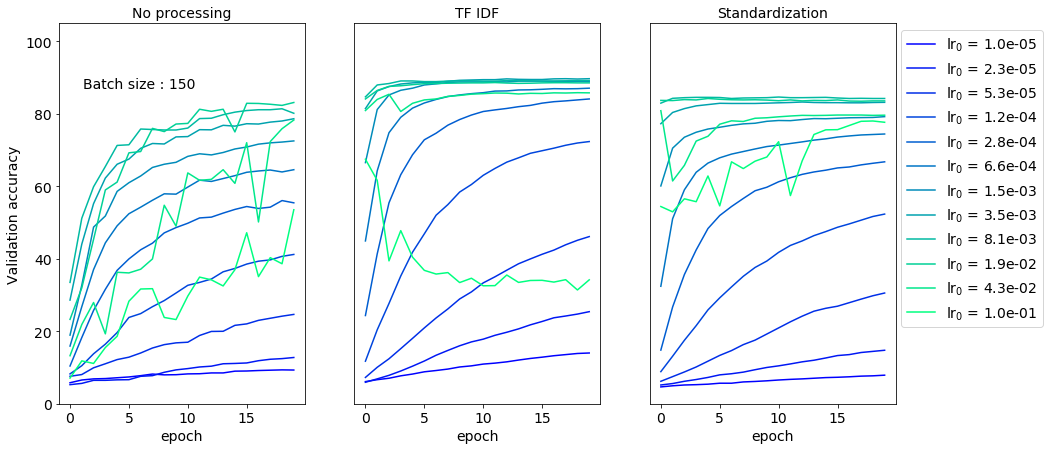

In [209]:
with open('SaveData/Q2/no_processing_tf_idf_standardization____bs_150___VariousLearningRate', 'rb') as f:
    loss_train, loss_valid, acc_train, acc_valid, hp  = pickle.load(f)
    
from matplotlib.pyplot import cm

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,7))

color=cm.winter(np.linspace(0,1,12))
cc= np.vstack((color,color,color))
lines = []    
tt = []
vv = []
ic=0
jc=0
kc = 0
title = ['No processing','TF IDF','Standardization']
axis = [ax1,ax2,ax3]
for i, (h) in enumerate(hp):
    if h[2]=='no_processing':
        ax1.plot(acc_valid[i,:],'-',color=cc[i])
    if h[2]=='tf_idf':
        ax2.plot(acc_valid[i,:],'-',color=cc[i],markerfacecolor='w')
    if h[2]=='standardization':
        lines += ax3.plot(acc_valid[i,:],'-',color=cc[i],label='lr$_0$ = %.1e'%hp[i][1])
    
labels = [l.get_label() for l in lines]
lg3=ax3.legend(lines, labels,loc='upper center', bbox_to_anchor=(1.31, 1),fontsize=14)

coordinates = [(ax1.get_xlim()[1] - ax1.get_xlim()[0]), (ax1.get_ylim()[1] - ax1.get_ylim()[0])]
xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()
ax1.text(0.1*(xmax - xmin) + xmin, 1*(ymax-ymin) + ymin,'Batch size : 150', fontsize=14)

for i, (ax,title) in enumerate(zip(axis,title)):    
    ax.set_ylim((0,105))
    ax.set_xlabel('epoch',fontsize=14)
    ax.set_title(title,fontsize=14)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
ax1.set_ylabel('Validation accuracy',fontsize=14)

ax2.axes.get_yaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)


plt.show()  
fig.savefig('Figures/Q2_Effect_of_learning_Rate.pdf',bbox_extra_artists=(lg3,), bbox_inches='tight')

### Variance

* The hyperparameters are set to lr = [0.4] and batch_size = 1, 100

* The training runs on one epoch only. 

* The training loss is recorded at EACH UPDATE. 

* The SHUFFLE option of torch.utils.data.DataLoader was set to FALSE 


In [ ]:
hyperparameters = np.hstack((np.array((1,100)).reshape(2,1),np.array((0.2, 0.2)).reshape(2,1),np.array((1,50)).reshape(2,1)))
# hyperparameters = np.hstack((np.array((1)).reshape(1,1),np.array((0.2)).reshape(1,1),np.array((1)).reshape(1,1)))
hp = []

for i,h in enumerate(hyperparameters): 
    hp.append([h[0],h[1],h[2],'tf_idf'])    

    
for i, h in enumerate(hp):
    print(h)

num_epochs = 1

n = len(hp)
m = num_epochs

loss_all =[]
acc_all = []
for i, (bs, lrs,n_e, method_) in enumerate((hp)):
    n_e = int(n_e)
    t0 = time.time()
    print('Iteration: '+str(i)+'/'+str(n))
    model = MLPLinear([h0,h1,h2],cuda)
    model.initialization('glorot')
    optimizer = optim.SGD(model.parameters(),lr=lrs)
    if method_ == 'no_processing':
        xt = train_x
        yt = train_y
        xv = valid_x
        yv = valid_y

    elif method_ == 'tf_idf':
        xt = train_x_idf
        yt = train_y
        xv = valid_x_idf
        yv = valid_y

    elif method_ == 'standardization':
        xt = train_x_std
        yt = train_y
        xv = valid_x_std
        yv = valid_y
  
    else: print('You made a mistake, pal! ')
    
    train_batch = torch.utils.data.DataLoader(data_utils.TensorDataset(xt,yt), batch_size=bs, shuffle=False)

    print('     ')
    print('     ')    
    print('Preprocessing procedures : '+method_+'   bs ='+str(bs)+'   lrs ='+str(lrs))
    print('________________________________')    
    loss_train = np.array([])
    acc_train = np.array([])
    for j in range(n_e):
        if j%10 == 0: print('epoch: '+str(j))
        model_loss = 0
        for i, (xx_,yy_) in enumerate(train_batch):
            xx,yy = model.input(xx_,yy_)
            pred_batch = model.forward(xx)
            loss_batch = model.criterion(pred_batch,yy)
            loss_train = np.append(loss_train,loss_batch.data[0])
            acc_train = np.append(acc_train, prediction_minibatch(pred_batch,yy))
        
            optimizer.zero_grad()
            loss_batch.backward()
            optimizer.step() 
    
    
    print(prediction(train_batch,model))
    
    ts = time.time()
    print('Time = %.2f sec'%(ts - t0))
    loss_all.append(loss_train)
    acc_all.append(acc_train)
print('done!')



99.93344425956738

6.78793256433008

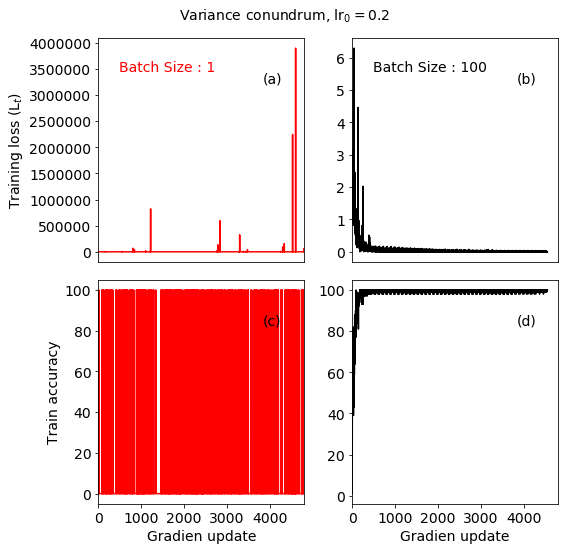

In [251]:

with open('SaveData/Q2/BatchSize_1_100_Variance', 'rb') as f:
    loss_all, acc_all,hp  = pickle.load(f)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
    
ind = 4800
ax1.plot(loss_all[0][:ind],'-r')
ax2.plot(loss_all[1][:ind],'-k')
ax3.plot(acc_all[0][:ind],'-r')
ax4.plot(acc_all[1][:ind],'-k')

labels = ['(a)','(b)','(c)','(d)']
for i, (ax,label) in enumerate(zip([ax1,ax2,ax3,ax4],labels)):
    if i == 0 or i == 2 or i == 4:
        ax.set_xlim((0,ind))
    if i == 1 or i == 3 or i == 5:
        ax.set_xlim((0,ind))        
    coordinates = [(ax.get_xlim()[1] - ax.get_xlim()[0]), (ax.get_ylim()[1] - ax.get_ylim()[0])]
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.text(0.8*(xmax - xmin) + xmin, 0.8*(ymax-ymin) + ymin,label, fontsize=14)

    if i == 0: 
        ax.text(0.1*(xmax - xmin) + xmin, 0.85*(ymax-ymin) + ymin,'Batch Size : 1', fontsize=14,color='r')
    if i == 1: 
        ax.text(0.1*(xmax - xmin) + xmin, 0.85*(ymax-ymin) + ymin,'Batch Size : 100', fontsize=14)        

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)        

ax1.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
        
ax1.set_ylabel('Training loss (L$_t$)',fontsize=14)
ax3.set_ylabel('Train accuracy',fontsize=14)

ax3.set_xlabel('Gradien update',fontsize=14)
ax4.set_xlabel('Gradien update',fontsize=14)

plt.suptitle('Variance conundrum, lr$_0 = 0.2$',fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()        



fig.savefig('Figures/Q2_variance.pdf')


In [207]:
# filename = 'SaveData/Q2/'# change name here. 
# with open(filename, 'wb') as f: 
#     pickle.dump([loss_all,acc_all, hp], f)
# print(filename)




SaveData/Q2/BatchSize_1_100_Variance
